# Bootstrap Distance Imposters

This method is novel, so as with all new things it should be taken with a grain of salt. One problem with GI (as discussed in the [GI Notebook](nux_imposters_poetics.ipynb)) is that it can be difficult to interpret at the high confidence end. This method extends the basic idea by measuring a complete _distance distribution_. In general, given a vector distance function $d(x,y)$ and some variables: $x$ an unknown text; $c_i \in C$ a set of candidate documents; and $y_j \in Y$ a set of imposter documents, GI estimates by boostrap the *single probability* that $min(d(x,C)) < min(d(x,Y))$ ('likelihood a candidate is closer than an imposter'). By contrast, this method records at each iteration $D \coloneqq min(d(x,Y)) - min(d(x,C))$ the _distance_ between the closest candidate and the closest imposter. For situations where $x$ is not by the candidate author we would expect $E[D] \approx 0$ (since the candidates are also imposters), whereas if the candidate is the true author the distance distribution will be centred around a positive number (distance to candidate tends to be less than distance to imposter). In situations of mistaken identity, when the true author is actually among the imposters, then $E[D]$ will be significantly below zero--something that is also not visible with GI. For those who desperately crave _p_-values, the probability mass that is less than zero represents the uncertainty.

This seems more (statistically) powerful in this particular application (look in particular at the uncertainty measures), and provides results that are much more interpretable, since results that are simply "1" in GI (a candidate text was closest in every iteration) will now return full distributions, even though every difference > 0.

The method was accepted after peer review as a full paper at [CHR 2024](https://ceur-ws.org/Vol-3834/) [direct link](https://ceur-ws.org/Vol-3834/paper61.pdf) which has much more detail.

In [12]:
import numpy as np
import pandas as pd
import scipy as sp

import heapq

from numpy.typing import NDArray
from typing import Callable

from sklearn.preprocessing import Normalizer, LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

from ruzicka.test_metrics import minmax
from ruzicka.BDIVerifier import BDIVerifier

## Corpus

See [this notebook](build_corpus.ipynb) for corpus creation details. I use Augustan 'short elegy' as elsewhere, but no poem that is less than twenty lines. For the poetic corpus, I use the vectorisation I created for previous work on Augustan elegy. It considers the following features:

<img src="./es_poetics_summary.png" alt="Drawing" style="width: 800px;"/>

In [3]:
vecs = pd.read_csv("elegy_poetic.csv", index_col=0)
corpus = vecs[vecs["LEN"] >= 20].reset_index(drop=True)

In [26]:
test_corpus = corpus[corpus.Author != "ps-Ovid"].reset_index(drop=True)
test_corpus

,Author,Work,Poem,H1SP,H2SP,H3SP,H4SP,H1CF,H2CF,H3CF,...,P4SC,P1WC,P2WC,P3WC,P4WC,ELC,RS,LEO,LEN,PFSD
0,Ovid,Ep.,Ep. 1,0.086207,0.500000,0.500000,0.448276,0.241379,0.706897,0.810345,...,0.000000,0.206897,0.068966,0.396552,1.000000,0.094828,4.393948,0.739842,116,0.000000
1,Ovid,Ep.,Ep. 2,0.189189,0.527027,0.581081,0.391892,0.283784,0.743243,0.878378,...,0.000000,0.202703,0.067568,0.337838,1.000000,0.114865,4.071062,1.027448,148,0.000000
2,Ovid,Ep.,Ep. 3,0.220779,0.493506,0.519481,0.480519,0.181818,0.597403,0.818182,...,0.000000,0.116883,0.025974,0.324675,1.000000,0.090909,3.845700,0.484285,154,0.000000
3,Ovid,Ep.,Ep. 4,0.102273,0.511364,0.545455,0.465909,0.147727,0.659091,0.829545,...,0.000000,0.215909,0.045455,0.329545,1.000000,0.073864,3.822098,0.893575,176,0.000000
4,Ovid,Ep.,Ep. 5,0.215190,0.455696,0.632911,0.417722,0.164557,0.658228,0.911392,...,0.000000,0.202532,0.037975,0.341772,1.000000,0.056962,3.727347,0.713715,158,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,Radulfus,RT,RT 5,0.626374,0.626374,0.604396,0.670330,0.296703,0.802198,0.978022,...,0.439560,0.131868,0.087912,0.307692,0.329670,0.000000,5.058660,3.290544,182,0.827341
284,Radulfus,RT,RT 6,0.463415,0.658537,0.707317,0.536585,0.268293,0.829268,1.000000,...,0.512195,0.195122,0.073171,0.365854,0.219512,0.000000,5.376182,2.472614,82,0.724148
285,Radulfus,RT,RT 7,0.503937,0.637795,0.692913,0.692913,0.307087,0.740157,0.968504,...,0.425197,0.110236,0.070866,0.236220,0.370079,0.000000,4.685756,1.988515,254,0.855370
286,Radulfus,RT,RT 8,0.423077,0.653846,0.653846,0.564103,0.179487,0.756410,0.987179,...,0.269231,0.102564,0.089744,0.282051,0.474359,0.006410,5.685010,3.316204,156,0.847417


In [27]:
problems = corpus[corpus.Author == "ps-Ovid"].reset_index(drop=True)
problems

,Author,Work,Poem,H1SP,H2SP,H3SP,H4SP,H1CF,H2CF,H3CF,...,P4SC,P1WC,P2WC,P3WC,P4WC,ELC,RS,LEO,LEN,PFSD
0,ps-Ovid,Nux,Nux,0.153846,0.450549,0.626374,0.626374,0.175824,0.604396,0.868132,...,0.000000,0.197802,0.043956,0.285714,1.000000,0.082418,3.095360,0.524756,182,0.000000
1,ps-Ovid,Medicamina,Medicamina,0.280000,0.480000,0.520000,0.540000,0.180000,0.620000,0.880000,...,0.000000,0.200000,0.040000,0.300000,1.000000,0.080000,4.901116,0.909967,100,0.000000
2,ps-Ovid,Pamphileas,Pamphileas,0.343434,0.505051,0.656566,0.616162,0.282828,0.636364,0.929293,...,0.010101,0.080808,0.121212,0.141414,0.959596,0.000000,4.120489,0.683937,198,0.357215
3,ps-Ovid,Consolatio,Consolatio 1,0.240506,0.481013,0.645570,0.531646,0.164557,0.582278,0.924051,...,0.000000,0.088608,0.037975,0.278481,1.000000,0.246835,4.619877,0.606677,158,0.000000
4,ps-Ovid,Consolatio,Consolatio 2,0.253165,0.556962,0.556962,0.493671,0.240506,0.696203,0.810127,...,0.000000,0.088608,0.025316,0.240506,1.000000,0.278481,3.608988,0.824542,158,0.000000
5,ps-Ovid,Consolatio,Consolatio 3,0.329114,0.506329,0.658228,0.582278,0.291139,0.594937,0.772152,...,0.000000,0.151899,0.037975,0.240506,0.987342,0.202532,4.590044,1.062847,158,0.225018
6,ps-Ovid,Ibis,Ibis 1,0.156250,0.718750,0.562500,0.593750,0.156250,0.562500,0.906250,...,0.000000,0.187500,0.000000,0.218750,1.000000,0.109375,3.986751,1.053890,64,0.000000
7,ps-Ovid,Ibis,Ibis 2,0.160000,0.530000,0.620000,0.440000,0.100000,0.580000,0.960000,...,0.000000,0.230000,0.060000,0.360000,1.000000,0.130000,4.683774,0.994626,200,0.000000
8,ps-Ovid,Ibis,Ibis 3,0.190000,0.450000,0.730000,0.550000,0.180000,0.730000,0.950000,...,0.000000,0.240000,0.050000,0.260000,1.000000,0.060000,4.070276,0.787213,200,0.000000
9,ps-Ovid,Ibis,Ibis 4,0.123596,0.438202,0.617978,0.528090,0.179775,0.685393,0.988764,...,0.000000,0.258427,0.056180,0.213483,0.977528,0.033708,4.358413,0.791811,178,0.471886


In [28]:
labels, label_uniques = test_corpus.Author.factorize()

## Methods

We z-scale the poetic features and then apply the MinMax metric (MinMax performed best in the [GI evaluation](nux_imposters_poetics.ipynb), and also at least 1% better than the best performing text-based classifier). The scaling is particularly important for the poetic feature vectors since the length (in lines)is on a very different scale to the feature percentages.

In [56]:
zscale = StandardScaler(with_mean=False)
X = np.array(zscale.fit_transform(test_corpus.drop(["Author", "Work", "Poem"], axis=1)))
y = labels

In [57]:
probs_X = np.array(zscale.transform(problems.drop(["Author", "Work", "Poem"], axis=1)))

In [58]:
problem_dict = dict(zip(problems.Poem, probs_X))

In [ ]:
# Create the verifier object
bdi_mm = BDIVerifier(
    metric="minmax",
    nb_bootstrap_iter=500,
    rnd_prop=0.35,
    random_state=np.random.default_rng(42),
)
bdi_mm.fit(X, y)

In [92]:
# label_uniques is a pandas Index of strings. The numeric labels index into these strings (i.e., they are
# in the same order)
collected = []
for label in label_uniques.values:
    # get_loc gives us the numeric label for a string
    code = label_uniques.get_loc(label)
    # make target labels the same length as the number of problem rows
    res = bdi_mm.predict_proba(probs_X, [code] * probs_X.shape[0], nb_imposters=-1)
    collected.append({label: list(zip(res, problems.Poem))})

In [93]:
collected_df = pd.DataFrame()
for d in collected:
    for k, v in d.items():
        vals, idx = zip(*v)
        collected_df[k] = pd.Series(vals, idx)

In [94]:
collected_df

,Ovid,Tibullus,Propertius,Catullus,Baldericus,Radulfus
Nux,0.988,0.000,0.002,0.0,0.000,0.000
Medicamina,0.992,0.000,0.016,0.0,0.000,0.000
Pamphileas,0.550,0.008,0.196,0.0,0.086,0.082
Consolatio 1,0.848,0.000,0.170,0.0,0.008,0.000
Consolatio 2,0.894,0.000,0.074,0.0,0.010,0.000
Consolatio 3,0.520,0.056,0.274,0.0,0.000,0.000
Ibis 1,0.996,0.000,0.000,0.0,0.000,0.000
Ibis 2,0.992,0.000,0.002,0.0,0.000,0.000
Ibis 3,0.998,0.000,0.000,0.0,0.000,0.000
Ibis 4,0.950,0.000,0.024,0.0,0.016,0.006


## Bubble Plot

This plot shows the match strength against each candidate. The BDI matches are not zero-sum—in other words an item can have a fairly substantial match against several candidates. This *seems* to indicate some kind of 'purity'. In other words, works that are very typical *and* unmistakeable for an other will have a high match strength against that candidate *and also* few matches to other candidates. The *Nux*, as we can see, is 'quintissentially Ovidian'.

The *Pamphileas* is a poor match to several authors, although it does show some affinity with Ovidian practice. It also matches the two Medieval authors (Baldericus and Radulfus) probably indicating changing metrical practices. Although this is not as interesting as the bubble plot for lexis, [cf](./nux_bdi_ngram.ipynb) ) we can clearly see that the Ovidian works are much 'purer' matches, showing once again that metrical analysis provides a cleaner authorial signal.

In [95]:
bubble = pd.melt(collected_df.reset_index(), id_vars="index")
bubble.columns = ["Work", "Author", "Match"]
bubble.head()

,Work,Author,Match
0,Nux,Ovid,0.988
1,Medicamina,Ovid,0.992
2,Pamphileas,Ovid,0.550
3,Consolatio 1,Ovid,0.848
4,Consolatio 2,Ovid,0.894


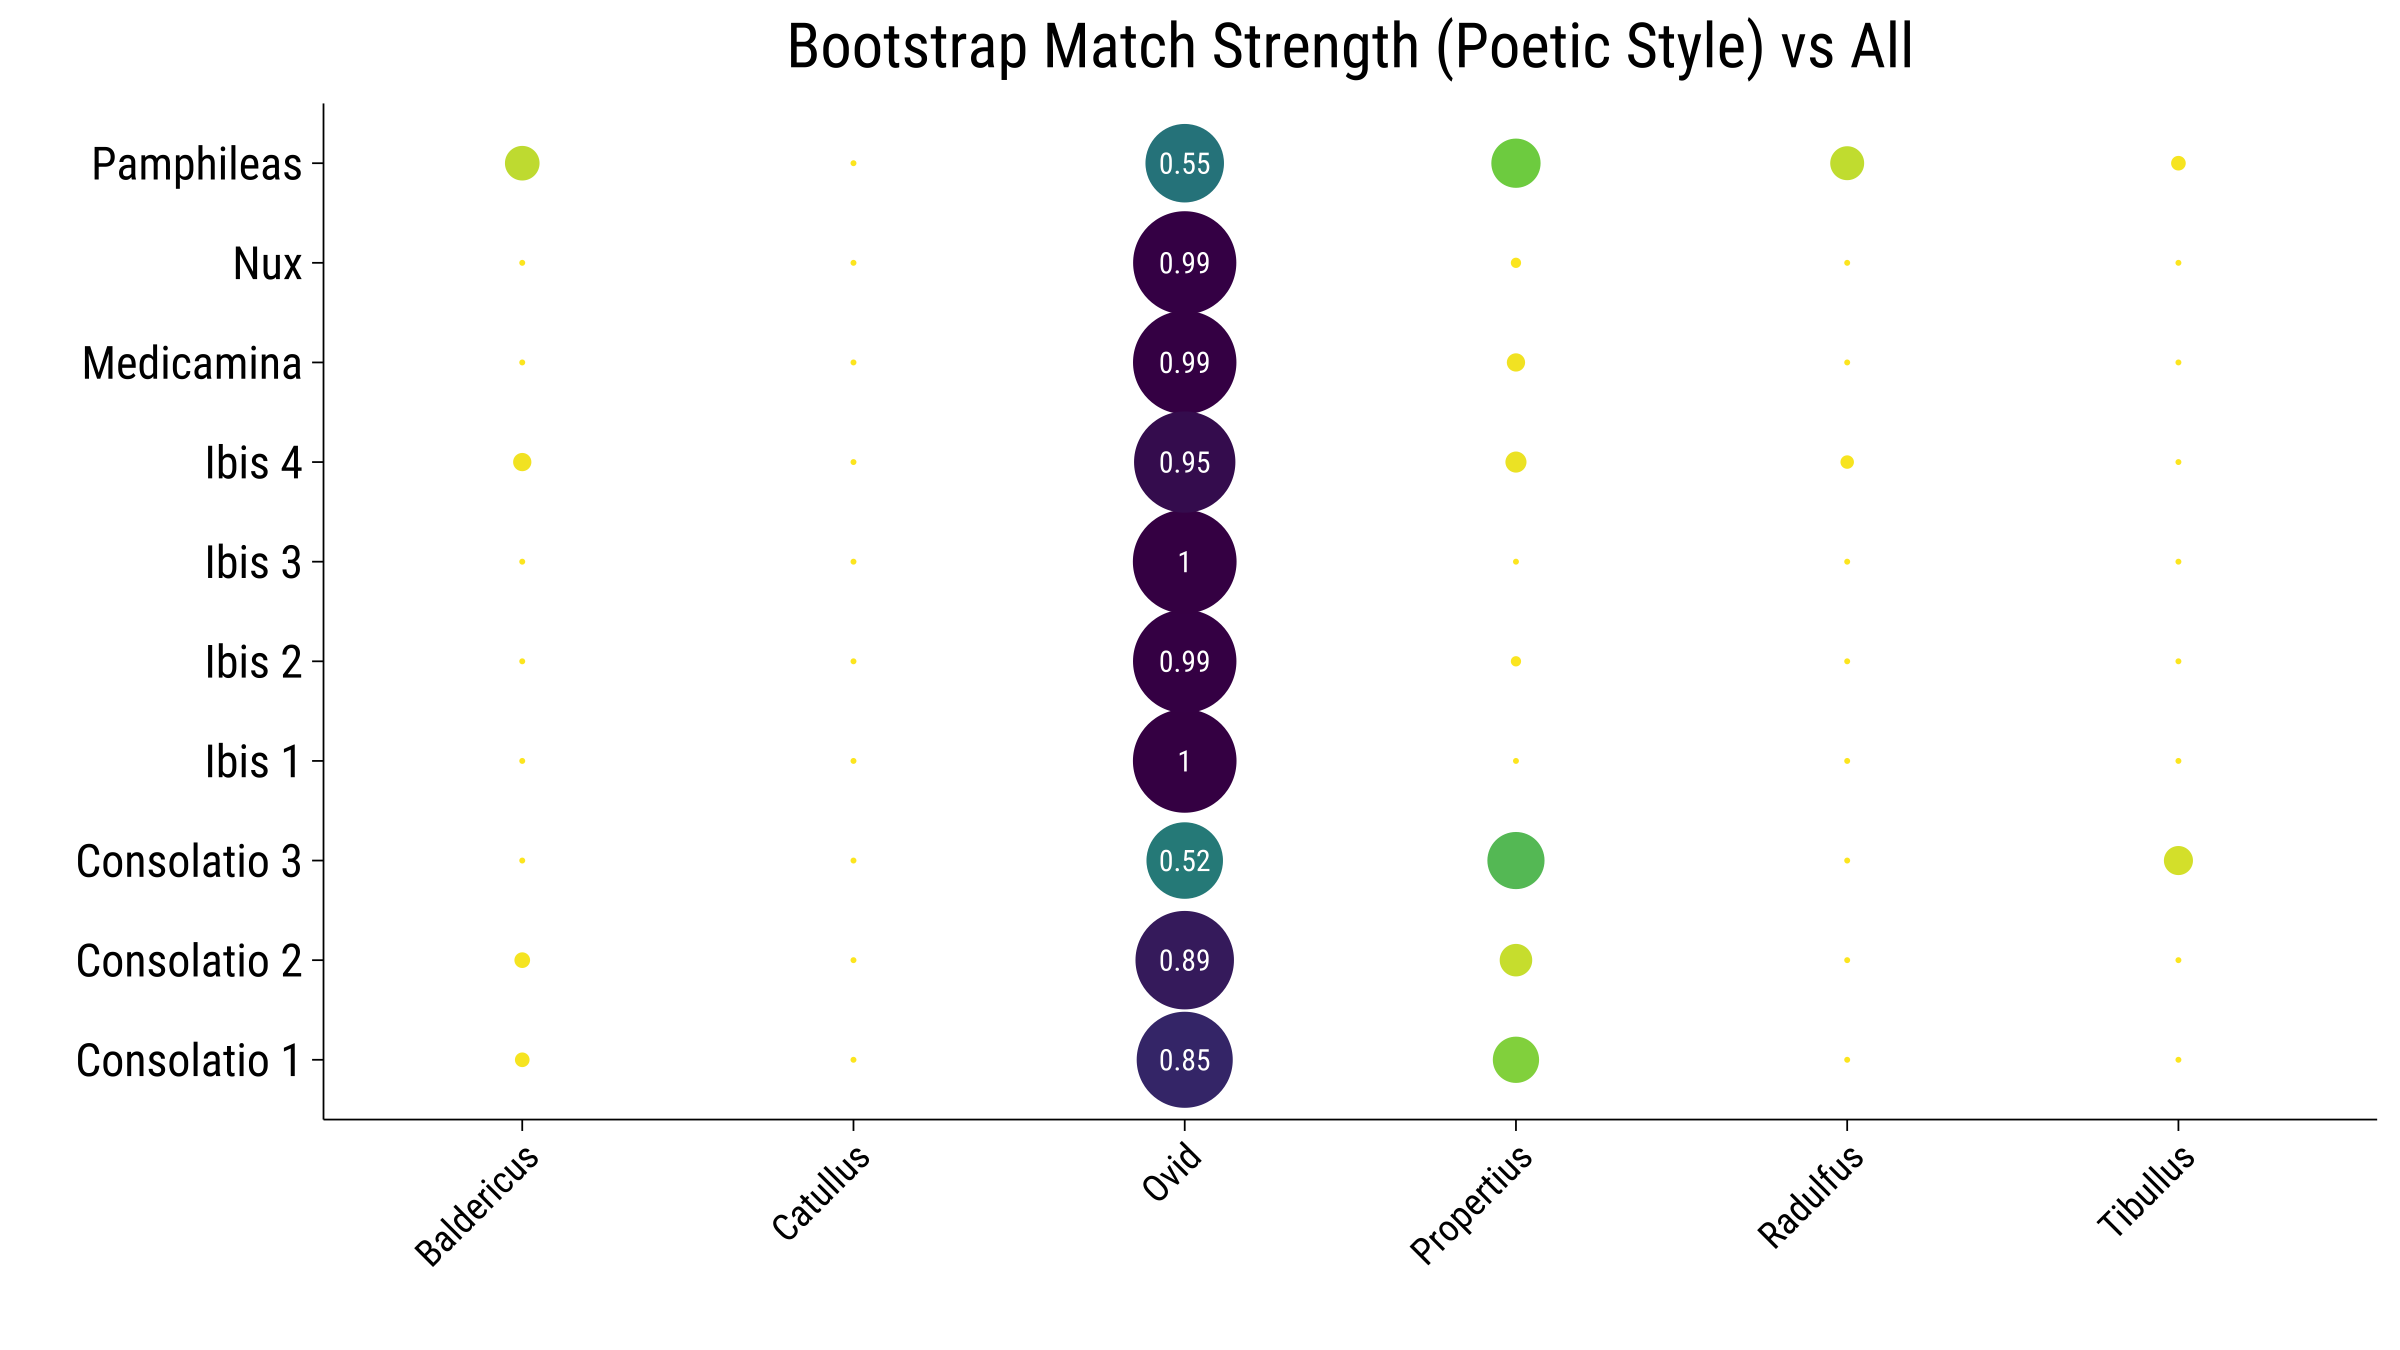

In [108]:
%%R -i bubble -h 4.5 -w 8 -u in -r 300
library(ggridges)
library(paletteer)
library(ggplot2)
library(showtext)
library(dplyr)
font_add_google("Roboto Condensed", "fnt")
showtext_auto()

data <- bubble
bgcol <- 'white'
fgcol <- 'black'
hi <- data %>% filter(Match > 0.5)

ggplot(data=data, aes(x=Author, y=Work)) +
geom_point(aes(size=Match,color=Match)) +
scale_size(range = c(0, 11)) + 
scale_color_viridis_c(direction = -1) +
geom_text(data=hi, aes(label=round(Match,2)),family='fnt',size=2.5, color=bgcol)+
theme_bw() +
xlab("") +
ylab("") +
ggtitle("Bootstrap Match Strength (Poetic Style) vs All") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol,color=bgcol),
    plot.title = element_text(hjust = 0.5, size=15, family="fnt", color=fgcol),
    axis.line.x=element_line(linewidth=0.2,color=fgcol),
    axis.line.y=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.x=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.y=element_line(linewidth=0.2,color=fgcol),
    axis.text.x=element_text(size=9, family="fnt", color=fgcol, angle=45,hjust=1),
    axis.text.y=element_text(size=11, family="fnt", color=fgcol),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
)
# fn <- "../figures/bdi_lexical_bubble.pdf"
# ggsave(fn, dpi=600, width=8, height=4.5, device=cairo_pdf)


## BDI Distance Distributions

Again, looking at metrical/poetic features gives us a much clearer result. The *Nux* is an excellent match for Ovidian practice, while the imitatio (*Consolatio ad Liviam*, *Pamphileas*) is not.

In [99]:
# re-run the verification, to populate the _dist_arrays property

bdi_mm = BDIVerifier(
    metric="minmax",
    nb_bootstrap_iter=500,
    rnd_prop=0.35,
    random_state=np.random.default_rng(42),
)

bdi_mm.fit(X, labels)

bdi_mm.predict_proba(
    probs_X,
    [label_uniques.get_loc("Ovid")] * probs_X.shape[0],
    nb_imposters=-1,
)

array([0.994, 0.976, 0.566, 0.834, 0.924, 0.514, 0.998, 0.99 , 1.   ,
       0.94 ])

In [100]:
ovid_df = pd.DataFrame(dict(zip(problems.Poem, bdi_mm._dist_arrays)))
ovid_df

,Nux,Medicamina,Pamphileas,Consolatio 1,Consolatio 2,Consolatio 3,Ibis 1,Ibis 2,Ibis 3,Ibis 4
0,0.044270,0.084459,0.032189,0.029087,0.023404,-0.054247,0.112226,0.067625,0.066116,-0.025905
1,0.072332,0.092045,0.027538,0.080635,0.006051,0.019182,0.050631,0.085505,0.076440,0.043643
2,0.029990,0.037977,-0.023737,-0.054740,0.038249,-0.062628,0.087318,0.079234,0.042200,0.073436
3,0.082690,0.098347,0.006387,0.032750,0.018989,-0.010449,0.071189,0.081597,0.065434,0.099452
4,0.034542,0.082880,0.004479,0.039194,0.024222,-0.027773,0.051847,0.046697,0.085432,0.008874
...,...,...,...,...,...,...,...,...,...,...
495,0.087446,0.077512,-0.002325,0.022213,0.073642,0.009974,0.045074,0.091733,0.081144,0.102494
496,0.179501,0.059041,0.043513,0.034303,0.034522,-0.000534,0.028736,0.147805,0.038219,0.158583
497,0.089031,0.053963,-0.035221,0.081958,-0.007441,0.029843,0.031063,0.131198,0.117538,0.135295
498,0.046295,0.039540,0.031958,0.066516,0.085973,0.002120,0.061706,0.019575,0.067829,0.045779


In [129]:
ovid_df.apply(
    lambda x: f"{sp.stats.percentileofscore(x, 0):.2f}% of bootstrap runs with negative distance"
)

Nux              0.60% of bootstrap runs with negative distance
Medicamina       2.40% of bootstrap runs with negative distance
Pamphileas      43.40% of bootstrap runs with negative distance
Consolatio 1    16.60% of bootstrap runs with negative distance
Consolatio 2     7.60% of bootstrap runs with negative distance
Consolatio 3    48.60% of bootstrap runs with negative distance
Ibis 1           0.20% of bootstrap runs with negative distance
Ibis 2           1.00% of bootstrap runs with negative distance
Ibis 3           0.00% of bootstrap runs with negative distance
Ibis 4           6.00% of bootstrap runs with negative distance
dtype: object

In [101]:
# for ggplot for this kind of plot it is easier to have 'long' tables, so we
# melt the dataframe so each observation for each text is a 'variable'. We add a
# column just so we can highlight the _Consolatio_ in a different colour.

ridge_df = pd.melt(ovid_df.T.reset_index(), id_vars="index")
ridge_df["highlight_color"] = "a"
ridge_df.loc[ridge_df["index"].str.startswith("Con"), "highlight_color"] = "b"
ridge_df.loc[ridge_df["index"].str.startswith("Pamp"), "highlight_color"] = "b"
ridge_df.loc[ridge_df["index"].str.startswith("Nux"), "highlight_color"] = "c"
ridge_df.head()

,index,variable,value,highlight_color
0,Nux,0,0.044270,c
1,Medicamina,0,0.084459,a
2,Pamphileas,0,0.032189,b
3,Consolatio 1,0,0.029087,b
4,Consolatio 2,0,0.023404,b


Picking joint bandwidth of 0.00902


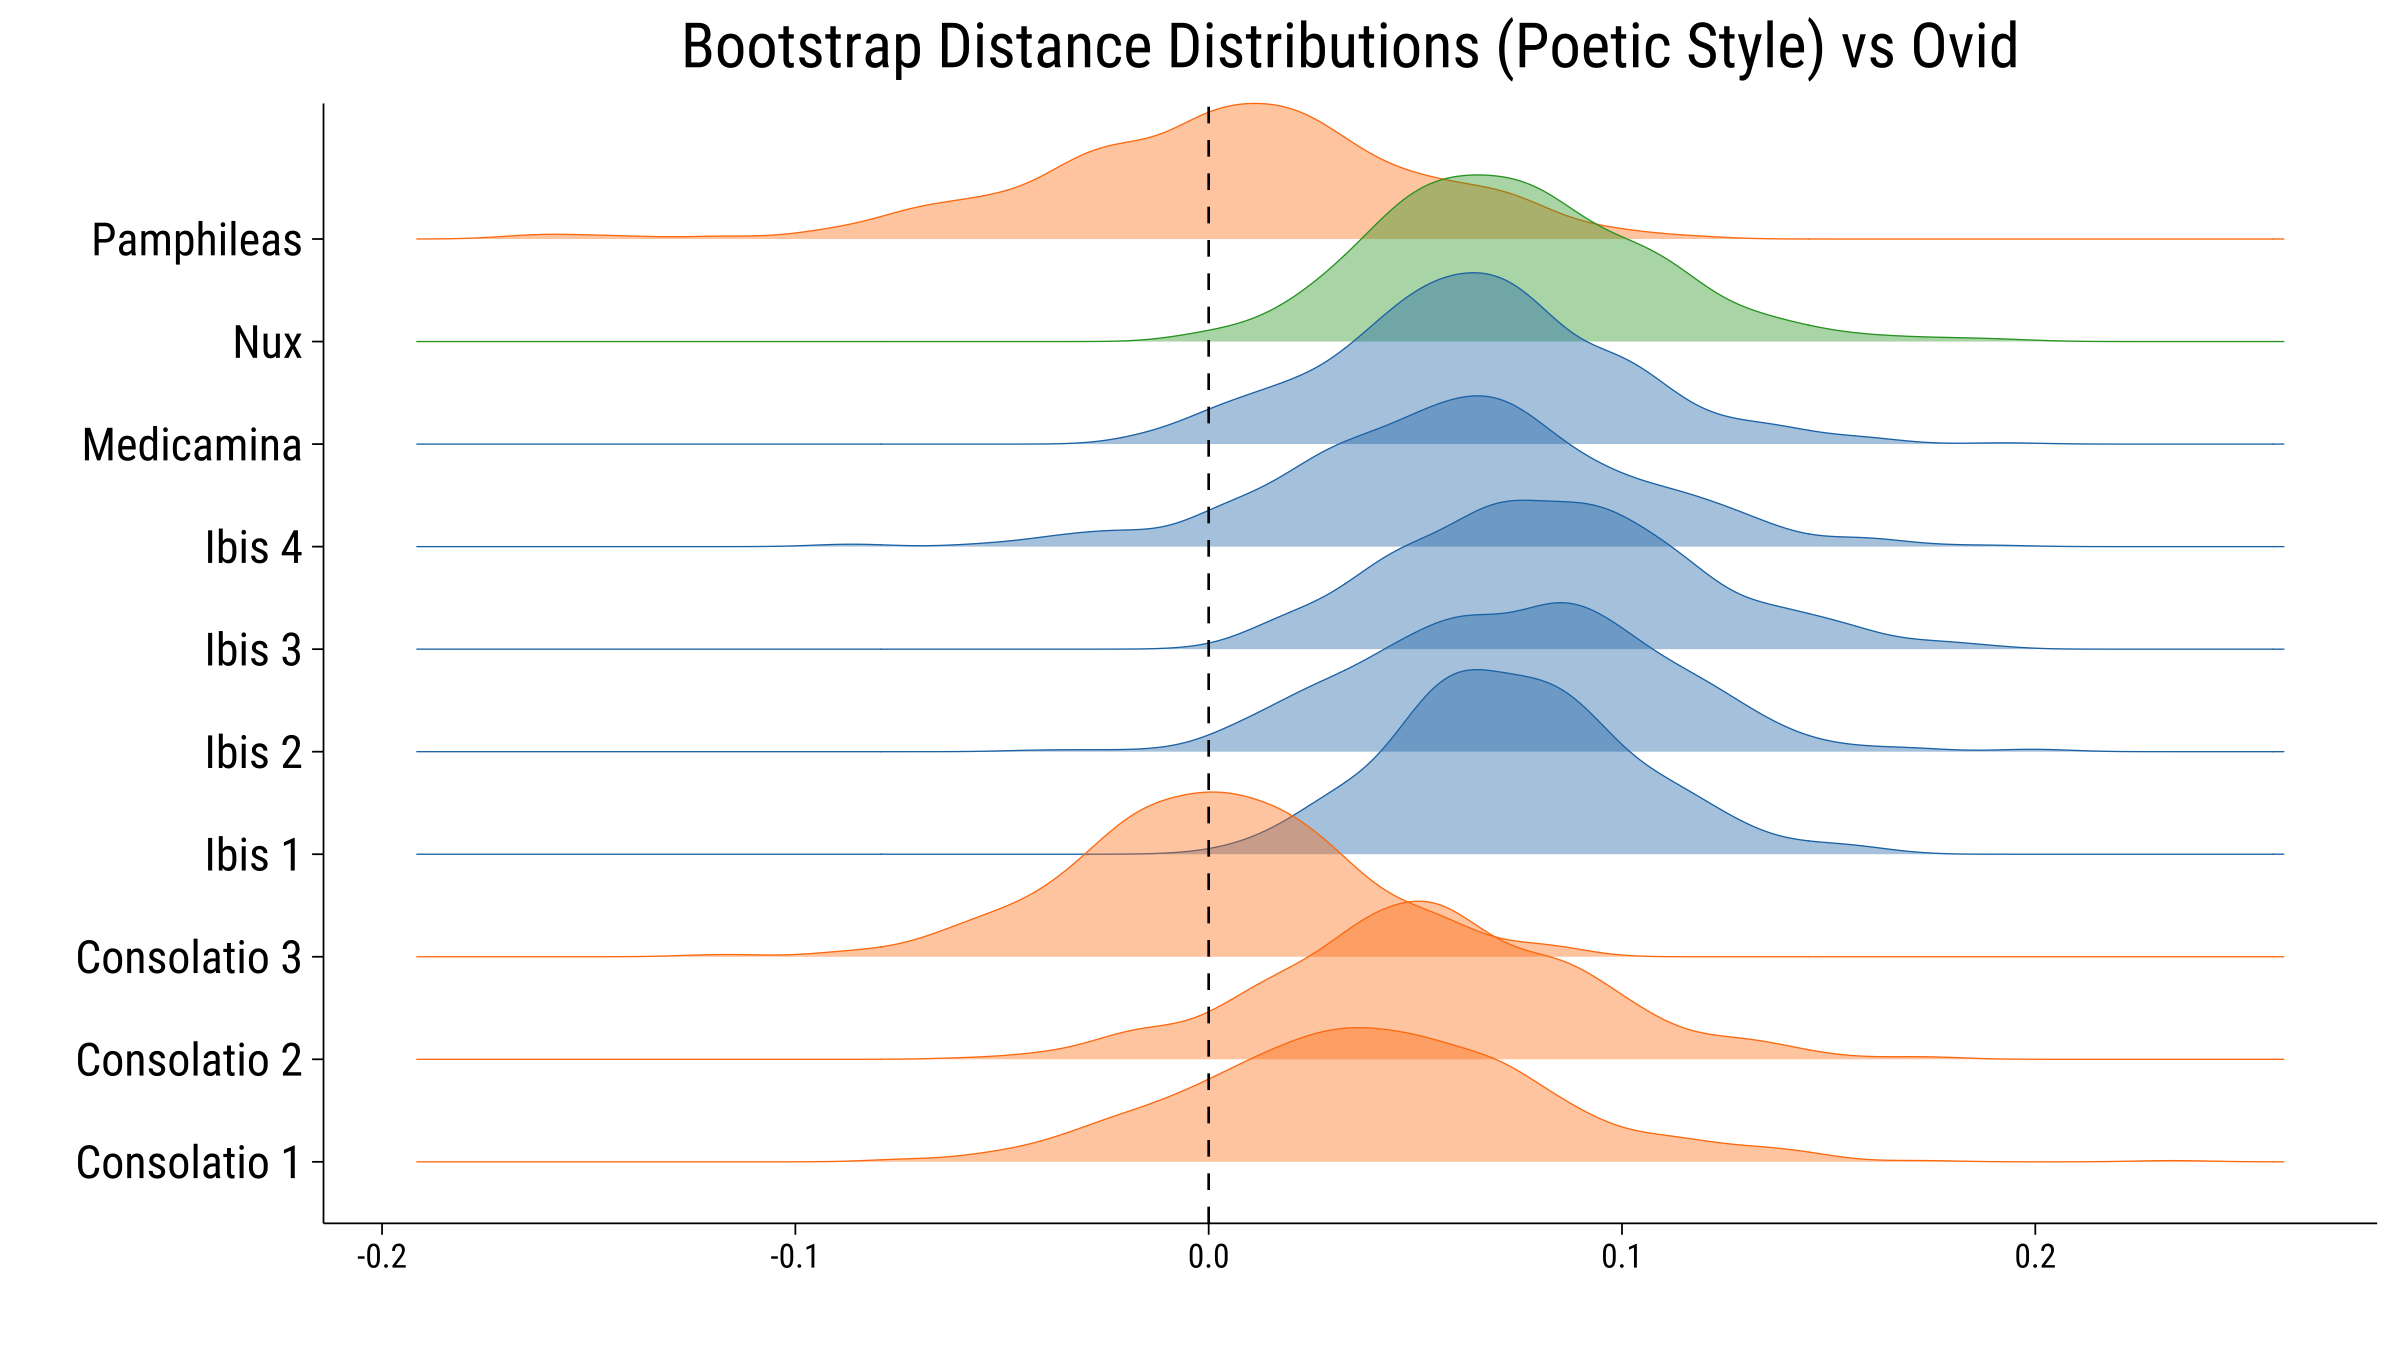

In [123]:
%%R -i ridge_df -h 4.5 -w 8 -u in -r 300
library(ggridges)
library(paletteer)
library(ggplot2)
library(showtext)
font_add_google("Roboto Condensed", "fnt")
showtext_auto()

plt <- "ggsci::category10_d3"
bgcol <- 'white'
fgcol <- 'black'
data <- ridge_df

p <- ggplot(data=data,aes(value,y=index,fill=highlight_color,color=highlight_color)) +
coord_cartesian(clip = "off") +

ggridges::stat_density_ridges(
    quantile_lines = FALSE, quantiles = 2, 
    alpha = .4,
    linewidth=0.15
) +
geom_vline(xintercept=0, colour=fgcol, linetype='dashed', linewidth=0.3) +
scale_y_discrete() +
scale_color_paletteer_d(plt) +
scale_fill_paletteer_d(plt) +
theme_bw() +
xlab("") +
ylab("") +
ggtitle("Bootstrap Distance Distributions (Poetic Style) vs Ovid") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol,color=bgcol),
    plot.title = element_text(hjust = 0.5, size=15, family="fnt", color=fgcol),
    axis.line.x=element_line(linewidth=0.2,color=fgcol),
    axis.line.y=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.x=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.y=element_line(linewidth=0.2,color=fgcol),
    axis.text.x=element_text(size=8, family="fnt", color=fgcol),
    axis.text.y=element_text(size=11, family="fnt", color=fgcol),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
)

# fn <- "../figures/bdi_poet_med.pdf"
# ggsave(plot=p, fn, dpi=600, width=8, height=4.5, device=cairo_pdf)
p
